In [1]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import time
from sklearn.metrics import make_scorer
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

깊이 튜닝

전부 fold 개수 336개임!!!!!!!!!!!!!!!

In [2]:
hyperparameters = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1),
        'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9],
        'subsample' : [0.8, 0.9]} # fix the n_estimators & eta(learning rate)

#tscv = TimeSeriesSplit(n_splits=3)
smape_score = make_scorer(SMAPE, greater_is_better=False)

for i in tqdm(np.arange(1, 101, 1)):
    train_df = pd.read_csv(f'./pretest/train_building{i}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    #merge = pd.concat([train_df,pretest_df])
    ################################################
    #하이퍼 파라미터 튜닝 method 1
    #leaf method
    print(f"__________Buildding Number:{i} Hyperparameter Tuning__________")

    preds = np.array([])
    smape_score = make_scorer(SMAPE, greater_is_better=False)
    grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1), 'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9], 'subsample' : [0.8, 0.9]} 
    grid_under = {}
    #합병된 데이터 사용
    y = train_df['power_consumption']
    x = train_df.drop(columns=['power_consumption'])
    #y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    #fit
    gcv = GridSearchCV(estimator = XGBRegressor(seed=0,tree_method="hist", gpu_id=0), param_grid=grid, scoring=smape_score, cv=PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168))) ,refit=True, verbose=False)
    gcv.fit(x, y)

    best = gcv.best_estimator_
    params = gcv.best_params_

    #pred
    x_pretest = pretest_df.drop(columns=['power_consumption'])
    y_pretest = pretest_df['power_consumption']
    pred = best.predict(x_pretest)
    print("_____Best Parameters_____",params)
    print("_____SMAPE Score________", SMAPE(y_pretest, pred))
    hyperparameters = pd.concat([hyperparameters,pd.DataFrame(params,index=[i-1])],axis=0)
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv', index=False) # save the tuned parameters


  0%|          | 0/100 [00:00<?, ?it/s]

__________Buildding Number:1 Hyperparameter Tuning__________


  1%|          | 1/100 [00:22<37:19, 22.62s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.82784571470689
__________Buildding Number:2 Hyperparameter Tuning__________


  2%|▏         | 2/100 [00:46<38:15, 23.42s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.96884310759437
__________Buildding Number:3 Hyperparameter Tuning__________


  3%|▎         | 3/100 [01:13<40:31, 25.06s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 35.92578083702007
__________Buildding Number:4 Hyperparameter Tuning__________


  4%|▍         | 4/100 [01:35<38:08, 23.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.515703705406175
__________Buildding Number:5 Hyperparameter Tuning__________


  5%|▌         | 5/100 [02:00<38:07, 24.08s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.11178983650232
__________Buildding Number:6 Hyperparameter Tuning__________


  6%|▌         | 6/100 [02:23<37:09, 23.72s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.97179763743785
__________Buildding Number:7 Hyperparameter Tuning__________


  7%|▋         | 7/100 [02:47<37:19, 24.09s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.42825130850712
__________Buildding Number:8 Hyperparameter Tuning__________


  8%|▊         | 8/100 [03:07<34:56, 22.79s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.11490280958733
__________Buildding Number:9 Hyperparameter Tuning__________


  9%|▉         | 9/100 [03:32<35:09, 23.18s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.04244365835008
__________Buildding Number:10 Hyperparameter Tuning__________


 10%|█         | 10/100 [03:55<34:59, 23.33s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 37.817509366473026
__________Buildding Number:11 Hyperparameter Tuning__________


 11%|█         | 11/100 [04:16<33:29, 22.58s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.237183789607336
__________Buildding Number:12 Hyperparameter Tuning__________


 12%|█▏        | 12/100 [04:39<33:28, 22.82s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.6896770999227
__________Buildding Number:13 Hyperparameter Tuning__________


 13%|█▎        | 13/100 [05:00<31:55, 22.02s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.6724658370534
__________Buildding Number:14 Hyperparameter Tuning__________


 14%|█▍        | 14/100 [05:22<31:50, 22.22s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 39.35919634999444
__________Buildding Number:15 Hyperparameter Tuning__________


 15%|█▌        | 15/100 [05:42<30:30, 21.53s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.1440007086085
__________Buildding Number:16 Hyperparameter Tuning__________


 16%|█▌        | 16/100 [06:05<30:34, 21.84s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.28268587807124
__________Buildding Number:17 Hyperparameter Tuning__________


 17%|█▋        | 17/100 [06:28<30:50, 22.29s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.31832311361631
__________Buildding Number:18 Hyperparameter Tuning__________


 18%|█▊        | 18/100 [06:52<31:01, 22.70s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.60755430764888
__________Buildding Number:19 Hyperparameter Tuning__________


 19%|█▉        | 19/100 [07:17<31:29, 23.32s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.10791242653812
__________Buildding Number:20 Hyperparameter Tuning__________


 20%|██        | 20/100 [07:41<31:42, 23.78s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.72496794963411
__________Buildding Number:21 Hyperparameter Tuning__________


 21%|██        | 21/100 [08:05<31:25, 23.86s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.70522924889403
__________Buildding Number:22 Hyperparameter Tuning__________


 22%|██▏       | 22/100 [08:27<30:07, 23.17s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.44597577688937
__________Buildding Number:23 Hyperparameter Tuning__________


 23%|██▎       | 23/100 [08:47<28:28, 22.18s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.46211114375834
__________Buildding Number:24 Hyperparameter Tuning__________


 24%|██▍       | 24/100 [09:09<28:11, 22.26s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.8808189039414
__________Buildding Number:25 Hyperparameter Tuning__________


 25%|██▌       | 25/100 [09:31<27:33, 22.05s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.921433363780025
__________Buildding Number:26 Hyperparameter Tuning__________


 26%|██▌       | 26/100 [09:54<27:27, 22.27s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.930576714319756
__________Buildding Number:27 Hyperparameter Tuning__________


 27%|██▋       | 27/100 [10:15<26:47, 22.02s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.13181461930653
__________Buildding Number:28 Hyperparameter Tuning__________


 28%|██▊       | 28/100 [10:38<26:44, 22.28s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 39.41689723105473
__________Buildding Number:29 Hyperparameter Tuning__________


 29%|██▉       | 29/100 [11:00<26:13, 22.16s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.61269939499883
__________Buildding Number:30 Hyperparameter Tuning__________


 30%|███       | 30/100 [11:25<26:48, 22.98s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.53798321362648
__________Buildding Number:31 Hyperparameter Tuning__________


 31%|███       | 31/100 [11:47<26:04, 22.67s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 40.40492617208684
__________Buildding Number:32 Hyperparameter Tuning__________


 32%|███▏      | 32/100 [12:02<23:04, 20.36s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.44994155924046
__________Buildding Number:33 Hyperparameter Tuning__________


 33%|███▎      | 33/100 [12:16<20:52, 18.70s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.058451074733576
__________Buildding Number:34 Hyperparameter Tuning__________


 34%|███▍      | 34/100 [12:32<19:27, 17.69s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.593465519651126
__________Buildding Number:35 Hyperparameter Tuning__________


 35%|███▌      | 35/100 [12:46<18:07, 16.74s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.99095620236869
__________Buildding Number:36 Hyperparameter Tuning__________


 36%|███▌      | 36/100 [12:59<16:42, 15.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.982425768552
__________Buildding Number:37 Hyperparameter Tuning__________


 37%|███▋      | 37/100 [13:24<19:10, 18.27s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.788518641033946
__________Buildding Number:38 Hyperparameter Tuning__________


 38%|███▊      | 38/100 [13:49<21:04, 20.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.897828368099404
__________Buildding Number:39 Hyperparameter Tuning__________


 39%|███▉      | 39/100 [14:13<21:49, 21.47s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.87951778436438
__________Buildding Number:40 Hyperparameter Tuning__________


 40%|████      | 40/100 [14:40<23:12, 23.21s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.920288511109405
__________Buildding Number:41 Hyperparameter Tuning__________


 41%|████      | 41/100 [15:05<23:18, 23.70s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.29776262676845
__________Buildding Number:42 Hyperparameter Tuning__________


 42%|████▏     | 42/100 [15:31<23:30, 24.32s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.18250425606567
__________Buildding Number:43 Hyperparameter Tuning__________


 43%|████▎     | 43/100 [15:55<22:57, 24.16s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.12742609340429
__________Buildding Number:44 Hyperparameter Tuning__________


 44%|████▍     | 44/100 [16:17<21:56, 23.52s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.89569157817316
__________Buildding Number:45 Hyperparameter Tuning__________


 45%|████▌     | 45/100 [16:38<21:02, 22.95s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.88291591578856
__________Buildding Number:46 Hyperparameter Tuning__________


 46%|████▌     | 46/100 [17:01<20:37, 22.93s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.72831047590981
__________Buildding Number:47 Hyperparameter Tuning__________


 47%|████▋     | 47/100 [17:22<19:45, 22.36s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.18208593692695
__________Buildding Number:48 Hyperparameter Tuning__________


 48%|████▊     | 48/100 [17:44<19:04, 22.00s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.95443841353939
__________Buildding Number:49 Hyperparameter Tuning__________


 49%|████▉     | 49/100 [18:05<18:34, 21.86s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.05878084134175
__________Buildding Number:50 Hyperparameter Tuning__________


 50%|█████     | 50/100 [18:27<18:17, 21.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.66030459206559
__________Buildding Number:51 Hyperparameter Tuning__________


 51%|█████     | 51/100 [18:50<18:10, 22.26s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.996339611825626
__________Buildding Number:52 Hyperparameter Tuning__________


 52%|█████▏    | 52/100 [19:14<18:06, 22.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.62751952546769
__________Buildding Number:53 Hyperparameter Tuning__________


 53%|█████▎    | 53/100 [19:40<18:32, 23.68s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 36.38702055059672
__________Buildding Number:54 Hyperparameter Tuning__________


 54%|█████▍    | 54/100 [20:06<18:48, 24.53s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 58.60034015243749
__________Buildding Number:55 Hyperparameter Tuning__________


 55%|█████▌    | 55/100 [20:23<16:42, 22.27s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.22325400301627
__________Buildding Number:56 Hyperparameter Tuning__________


 56%|█████▌    | 56/100 [20:40<15:12, 20.73s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.516462342058276
__________Buildding Number:57 Hyperparameter Tuning__________


 57%|█████▋    | 57/100 [21:03<15:20, 21.41s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.84459198829848
__________Buildding Number:58 Hyperparameter Tuning__________


 58%|█████▊    | 58/100 [21:18<13:34, 19.39s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.51838899832923
__________Buildding Number:59 Hyperparameter Tuning__________


 59%|█████▉    | 59/100 [21:43<14:19, 20.97s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.176900068477714
__________Buildding Number:60 Hyperparameter Tuning__________


 60%|██████    | 60/100 [22:05<14:18, 21.46s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.48133534207455
__________Buildding Number:61 Hyperparameter Tuning__________


 61%|██████    | 61/100 [22:31<14:41, 22.61s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.61900653209491
__________Buildding Number:62 Hyperparameter Tuning__________


 62%|██████▏   | 62/100 [22:56<14:54, 23.54s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.296892055483276
__________Buildding Number:63 Hyperparameter Tuning__________


 63%|██████▎   | 63/100 [23:22<14:52, 24.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 42.24894786810032
__________Buildding Number:64 Hyperparameter Tuning__________


 64%|██████▍   | 64/100 [23:45<14:21, 23.94s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.81764859465435
__________Buildding Number:65 Hyperparameter Tuning__________


 65%|██████▌   | 65/100 [24:10<14:09, 24.28s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 38.14946246422009
__________Buildding Number:66 Hyperparameter Tuning__________


 66%|██████▌   | 66/100 [24:32<13:21, 23.58s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.76674414843881
__________Buildding Number:67 Hyperparameter Tuning__________


 67%|██████▋   | 67/100 [24:56<12:58, 23.59s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 36.078769220626775
__________Buildding Number:68 Hyperparameter Tuning__________


 68%|██████▊   | 68/100 [25:20<12:39, 23.73s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.805813379150024
__________Buildding Number:69 Hyperparameter Tuning__________


 69%|██████▉   | 69/100 [25:42<12:02, 23.30s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.73595923330011
__________Buildding Number:70 Hyperparameter Tuning__________


 70%|███████   | 70/100 [26:08<11:57, 23.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 53.629897392551364
__________Buildding Number:71 Hyperparameter Tuning__________


 71%|███████   | 71/100 [26:32<11:32, 23.87s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.059351528080704
__________Buildding Number:72 Hyperparameter Tuning__________


 72%|███████▏  | 72/100 [26:51<10:33, 22.63s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 47.25586449240257
__________Buildding Number:73 Hyperparameter Tuning__________


 73%|███████▎  | 73/100 [27:12<09:57, 22.12s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.201603451110834
__________Buildding Number:74 Hyperparameter Tuning__________


 74%|███████▍  | 74/100 [27:36<09:45, 22.52s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.69033331631594
__________Buildding Number:75 Hyperparameter Tuning__________


 75%|███████▌  | 75/100 [28:00<09:37, 23.11s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.75691336229737
__________Buildding Number:76 Hyperparameter Tuning__________


 76%|███████▌  | 76/100 [28:21<08:58, 22.43s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 45.43634542847347
__________Buildding Number:77 Hyperparameter Tuning__________


 77%|███████▋  | 77/100 [28:44<08:41, 22.67s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.12289191955067
__________Buildding Number:78 Hyperparameter Tuning__________


 78%|███████▊  | 78/100 [29:04<07:58, 21.75s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.092218926465655
__________Buildding Number:79 Hyperparameter Tuning__________


 79%|███████▉  | 79/100 [29:24<07:27, 21.30s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.94362684416368
__________Buildding Number:80 Hyperparameter Tuning__________


 80%|████████  | 80/100 [29:44<06:56, 20.83s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.99419931474999
__________Buildding Number:81 Hyperparameter Tuning__________


 81%|████████  | 81/100 [30:03<06:24, 20.21s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.70653643972136
__________Buildding Number:82 Hyperparameter Tuning__________


 82%|████████▏ | 82/100 [30:23<06:02, 20.14s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 44.09743527087139
__________Buildding Number:83 Hyperparameter Tuning__________


 83%|████████▎ | 83/100 [30:42<05:40, 20.05s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 46.01690560791188
__________Buildding Number:84 Hyperparameter Tuning__________


 84%|████████▍ | 84/100 [31:01<05:15, 19.71s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.1461201534055
__________Buildding Number:85 Hyperparameter Tuning__________


 85%|████████▌ | 85/100 [31:19<04:45, 19.05s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.16094762260554
__________Buildding Number:86 Hyperparameter Tuning__________


 86%|████████▌ | 86/100 [31:39<04:29, 19.27s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.58599013330516
__________Buildding Number:87 Hyperparameter Tuning__________


 87%|████████▋ | 87/100 [32:01<04:24, 20.34s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.36433324259843
__________Buildding Number:88 Hyperparameter Tuning__________


 88%|████████▊ | 88/100 [32:23<04:07, 20.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.11404605555894
__________Buildding Number:89 Hyperparameter Tuning__________


 89%|████████▉ | 89/100 [32:44<03:50, 20.92s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 49.638665487416944
__________Buildding Number:90 Hyperparameter Tuning__________


 90%|█████████ | 90/100 [33:06<03:30, 21.05s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 50.13334474447774
__________Buildding Number:91 Hyperparameter Tuning__________


 91%|█████████ | 91/100 [33:26<03:06, 20.73s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 48.26831096955007
__________Buildding Number:92 Hyperparameter Tuning__________


 92%|█████████▏| 92/100 [33:46<02:44, 20.55s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.943620395084146
__________Buildding Number:93 Hyperparameter Tuning__________


 93%|█████████▎| 93/100 [34:05<02:20, 20.01s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 43.227257510128325
__________Buildding Number:94 Hyperparameter Tuning__________


 94%|█████████▍| 94/100 [34:24<01:58, 19.82s/it]

_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 46.02748710624537
__________Buildding Number:95 Hyperparameter Tuning__________


 95%|█████████▌| 95/100 [34:44<01:39, 19.93s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 32.97348376958116
__________Buildding Number:96 Hyperparameter Tuning__________


 96%|█████████▌| 96/100 [35:03<01:17, 19.49s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 41.0958539155093
__________Buildding Number:97 Hyperparameter Tuning__________


 97%|█████████▋| 97/100 [35:22<00:57, 19.31s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 48.146152409879186
__________Buildding Number:98 Hyperparameter Tuning__________


 98%|█████████▊| 98/100 [35:42<00:39, 19.66s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 36.97157938782777
__________Buildding Number:99 Hyperparameter Tuning__________


 99%|█████████▉| 99/100 [36:01<00:19, 19.40s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 44.26798393563308
__________Buildding Number:100 Hyperparameter Tuning__________


100%|██████████| 100/100 [36:20<00:00, 21.81s/it]

_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 47.284335937796854


n_estimators 튜닝

In [3]:
#n_estimators
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb_reg = XGBRegressor(n_estimators = 10000, tree_method="hist",  gpu_id=0, 
                           eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], 
                           seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    
    y_pred = xgb_reg.predict(p_x)
    pred = pd.Series(y_pred)
    
    sm = SMAPE(p_y, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration+1) ## 실제 best iteration은 이 값에 +1 해주어야 함.
hyperparameters['best_it'] = best_it

100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


alpha튜닝

In [4]:
xgb_params = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')
#alpha
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    
    ################################################
    t_y = train_df['power_consumption']
    t_x = train_df.drop(['power_consumption'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = t_y, X = t_x, test_size = 168)
    
    
    p_y = pretest_df['power_consumption']
    p_x = pretest_df.drop(['power_consumption'], axis=1)

    xgb = XGBRegressor(seed = 0, tree_method="hist",  gpu_id=0,
                      n_estimators = best_it[i], 
                      eta = 0.01, 
                      min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], 
                      colsample_bytree = xgb_params.iloc[i, 4], 
                      subsample = xgb_params.iloc[i, 5])

    xgb.fit(x_train, y_train ,verbose=False)
    pred0 = xgb.predict(x_valid)
    best_alpha = 0
    score0 = SMAPE(y_valid,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators =  best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train,verbose=False)
        
        pred1 = xgb.predict(x_valid)
        score1 = SMAPE(y_valid, pred1)
        if score1 < score0: 
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))
    
    
hyperparameters['alpha'] = alpha_list

  1%|          | 1/100 [00:05<08:24,  5.09s/it]

building 1 || best score : 8.122792311217118 || alpha : 5


  2%|▏         | 2/100 [00:12<10:09,  6.22s/it]

building 2 || best score : 9.989104373733001 || alpha : 100


  3%|▎         | 3/100 [00:19<10:45,  6.65s/it]

building 3 || best score : 12.673009999818248 || alpha : 10


  4%|▍         | 4/100 [00:26<11:06,  6.94s/it]

building 4 || best score : 4.523322606465539 || alpha : 100


  5%|▌         | 5/100 [00:54<22:57, 14.50s/it]

building 5 || best score : 5.946404948599105 || alpha : 3


  6%|▌         | 6/100 [01:01<18:35, 11.87s/it]

building 6 || best score : 3.93881349828241 || alpha : 50


  7%|▋         | 7/100 [01:04<13:58,  9.02s/it]

building 7 || best score : 8.415674763403857 || alpha : 7


  8%|▊         | 8/100 [01:09<11:59,  7.83s/it]

building 8 || best score : 4.960139668945992 || alpha : 100


  9%|▉         | 9/100 [01:19<12:35,  8.30s/it]

building 9 || best score : 3.7570972588953473 || alpha : 100


 10%|█         | 10/100 [01:23<10:28,  6.99s/it]

building 10 || best score : 5.863270894556702 || alpha : 5


 11%|█         | 11/100 [01:27<09:00,  6.08s/it]

building 11 || best score : 4.082111647439144 || alpha : 10


 12%|█▏        | 12/100 [01:32<08:48,  6.01s/it]

building 12 || best score : 5.290673760022015 || alpha : 100


 13%|█▎        | 13/100 [01:38<08:30,  5.87s/it]

building 13 || best score : 6.226048135747878 || alpha : 1


 14%|█▍        | 14/100 [01:41<06:57,  4.86s/it]

building 14 || best score : 16.017240187163974 || alpha : 5


 15%|█▌        | 15/100 [01:45<06:47,  4.80s/it]

building 15 || best score : 3.9227114677049624 || alpha : 5


 16%|█▌        | 16/100 [01:52<07:25,  5.30s/it]

building 16 || best score : 3.5748651590172016 || alpha : 75


 17%|█▋        | 17/100 [01:55<06:33,  4.74s/it]

building 17 || best score : 6.542569891879135 || alpha : 25


 18%|█▊        | 18/100 [02:00<06:41,  4.90s/it]

building 18 || best score : 5.905777851432185 || alpha : 10


 19%|█▉        | 19/100 [02:04<05:59,  4.44s/it]

building 19 || best score : 8.28150244654655 || alpha : 0


 20%|██        | 20/100 [02:13<08:01,  6.02s/it]

building 20 || best score : 5.135705287445746 || alpha : 50


 21%|██        | 21/100 [02:20<08:18,  6.31s/it]

building 21 || best score : 7.382838777683104 || alpha : 0


 22%|██▏       | 22/100 [02:25<07:21,  5.67s/it]

building 22 || best score : 3.714037608902726 || alpha : 0


 23%|██▎       | 23/100 [02:29<06:40,  5.21s/it]

building 23 || best score : 3.6107239368755106 || alpha : 100


 24%|██▍       | 24/100 [02:33<06:03,  4.78s/it]

building 24 || best score : 4.951382609407428 || alpha : 100


 25%|██▌       | 25/100 [02:39<06:31,  5.23s/it]

building 25 || best score : 2.7481346720368323 || alpha : 75


 26%|██▌       | 26/100 [02:44<06:20,  5.14s/it]

building 26 || best score : 4.681782655922616 || alpha : 50


 27%|██▋       | 27/100 [02:48<06:06,  5.02s/it]

building 27 || best score : 2.996340315587988 || alpha : 100


 28%|██▊       | 28/100 [03:05<10:05,  8.41s/it]

building 28 || best score : 6.1268782611872865 || alpha : 25


 29%|██▉       | 29/100 [03:08<08:15,  6.98s/it]

building 29 || best score : 5.60730806425277 || alpha : 100


 30%|███       | 30/100 [03:13<07:22,  6.33s/it]

building 30 || best score : 6.727593686302196 || alpha : 0


 31%|███       | 31/100 [03:19<07:12,  6.26s/it]

building 31 || best score : 5.907490795337519 || alpha : 100


 32%|███▏      | 32/100 [03:24<06:37,  5.84s/it]

building 32 || best score : 0.32371141344373505 || alpha : 25


 33%|███▎      | 33/100 [03:30<06:29,  5.81s/it]

building 33 || best score : 0.3621157299566673 || alpha : 1


 34%|███▍      | 34/100 [03:35<06:08,  5.59s/it]

building 34 || best score : 0.5607482356796001 || alpha : 100


 35%|███▌      | 35/100 [03:41<06:12,  5.73s/it]

building 35 || best score : 0.46733461143343524 || alpha : 10


 36%|███▌      | 36/100 [03:46<06:00,  5.63s/it]

building 36 || best score : 0.8118521053437675 || alpha : 75


 37%|███▋      | 37/100 [03:51<05:42,  5.43s/it]

building 37 || best score : 6.044177365419672 || alpha : 25


 38%|███▊      | 38/100 [03:54<04:41,  4.54s/it]

building 38 || best score : 13.7035421850367 || alpha : 25


 39%|███▉      | 39/100 [03:58<04:27,  4.38s/it]

building 39 || best score : 9.55196891080989 || alpha : 75


 40%|████      | 40/100 [04:04<04:49,  4.83s/it]

building 40 || best score : 16.7046004035831 || alpha : 7


 41%|████      | 41/100 [04:17<07:12,  7.34s/it]

building 41 || best score : 8.007681004749404 || alpha : 0


 42%|████▏     | 42/100 [04:23<06:39,  6.89s/it]

building 42 || best score : 3.216311010202876 || alpha : 25


 43%|████▎     | 43/100 [04:28<05:55,  6.24s/it]

building 43 || best score : 4.59025793227301 || alpha : 0


 44%|████▍     | 44/100 [04:39<07:09,  7.68s/it]

building 44 || best score : 5.412355801087647 || alpha : 5


 45%|████▌     | 45/100 [04:46<06:58,  7.61s/it]

building 45 || best score : 3.1272091982845125 || alpha : 100


 46%|████▌     | 46/100 [04:51<06:00,  6.68s/it]

building 46 || best score : 5.444619959467835 || alpha : 25


 47%|████▋     | 47/100 [04:54<05:09,  5.84s/it]

building 47 || best score : 5.188171047493124 || alpha : 25


 48%|████▊     | 48/100 [05:00<05:04,  5.86s/it]

building 48 || best score : 3.3786130521010667 || alpha : 25


 49%|████▉     | 49/100 [05:08<05:24,  6.36s/it]

building 49 || best score : 3.0986830905034184 || alpha : 50


 50%|█████     | 50/100 [05:18<06:14,  7.48s/it]

building 50 || best score : 2.736442424335972 || alpha : 100


 51%|█████     | 51/100 [05:25<05:53,  7.21s/it]

building 51 || best score : 4.79854343568469 || alpha : 50


 52%|█████▏    | 52/100 [05:30<05:23,  6.73s/it]

building 52 || best score : 3.760459308796927 || alpha : 25


 53%|█████▎    | 53/100 [05:33<04:19,  5.53s/it]

building 53 || best score : 11.846378889929667 || alpha : 1


 54%|█████▍    | 54/100 [05:35<03:32,  4.63s/it]

building 54 || best score : 25.13086960226275 || alpha : 0


 55%|█████▌    | 55/100 [05:40<03:29,  4.65s/it]

building 55 || best score : 1.4842007134328752 || alpha : 0


 56%|█████▌    | 56/100 [05:45<03:29,  4.76s/it]

building 56 || best score : 0.9789659289156087 || alpha : 0


 57%|█████▋    | 57/100 [05:50<03:28,  4.85s/it]

building 57 || best score : 5.962077301306511 || alpha : 0


 58%|█████▊    | 58/100 [05:56<03:32,  5.06s/it]

building 58 || best score : 0.5368730020295572 || alpha : 7


 59%|█████▉    | 59/100 [06:01<03:25,  5.02s/it]

building 59 || best score : 7.7452168992740384 || alpha : 5


 60%|██████    | 60/100 [06:10<04:09,  6.23s/it]

building 60 || best score : 6.675731391363886 || alpha : 0


 61%|██████    | 61/100 [06:14<03:40,  5.67s/it]

building 61 || best score : 4.810193962804203 || alpha : 25


 62%|██████▏   | 62/100 [06:18<03:17,  5.19s/it]

building 62 || best score : 5.993717981825754 || alpha : 1


 63%|██████▎   | 63/100 [06:34<05:13,  8.48s/it]

building 63 || best score : 4.872172705031212 || alpha : 0


 64%|██████▍   | 64/100 [06:40<04:33,  7.61s/it]

building 64 || best score : 3.722637960108898 || alpha : 5


 65%|██████▌   | 65/100 [06:53<05:26,  9.34s/it]

building 65 || best score : 11.214119115534164 || alpha : 0


 66%|██████▌   | 66/100 [07:01<04:59,  8.81s/it]

building 66 || best score : 3.434895100888354 || alpha : 100


 67%|██████▋   | 67/100 [07:10<04:54,  8.93s/it]

building 67 || best score : 6.536503661520895 || alpha : 100


 68%|██████▊   | 68/100 [07:16<04:16,  8.01s/it]

building 68 || best score : 4.546851410392326 || alpha : 1


 69%|██████▉   | 69/100 [07:54<08:51, 17.14s/it]

building 69 || best score : 3.8897534544490577 || alpha : 0


 70%|███████   | 70/100 [07:58<06:33, 13.10s/it]

building 70 || best score : 29.421848229317487 || alpha : 100


 71%|███████   | 71/100 [08:02<05:02, 10.44s/it]

building 71 || best score : 6.054344751067163 || alpha : 50


 72%|███████▏  | 72/100 [08:10<04:31,  9.69s/it]

building 72 || best score : 6.068802074844383 || alpha : 100


 73%|███████▎  | 73/100 [08:15<03:45,  8.35s/it]

building 73 || best score : 3.7691865679587724 || alpha : 100


 74%|███████▍  | 74/100 [08:19<03:01,  7.00s/it]

building 74 || best score : 6.947713193187832 || alpha : 50


 75%|███████▌  | 75/100 [08:25<02:48,  6.74s/it]

building 75 || best score : 3.8128019325326665 || alpha : 100


 76%|███████▌  | 76/100 [08:30<02:28,  6.18s/it]

building 76 || best score : 4.919140814828237 || alpha : 100


 77%|███████▋  | 77/100 [08:37<02:25,  6.33s/it]

building 77 || best score : 2.948345119474271 || alpha : 25


 78%|███████▊  | 78/100 [08:43<02:17,  6.23s/it]

building 78 || best score : 5.893017401046593 || alpha : 25


 79%|███████▉  | 79/100 [08:47<01:58,  5.64s/it]

building 79 || best score : 3.9708053086066104 || alpha : 100


 80%|████████  | 80/100 [09:04<02:57,  8.87s/it]

building 80 || best score : 8.390740450099823 || alpha : 50


 81%|████████  | 81/100 [09:10<02:35,  8.18s/it]

building 81 || best score : 3.428087226464992 || alpha : 5


 82%|████████▏ | 82/100 [09:17<02:18,  7.68s/it]

building 82 || best score : 9.073260704118445 || alpha : 100


 83%|████████▎ | 83/100 [09:21<01:52,  6.60s/it]

building 83 || best score : 8.23197437340533 || alpha : 75


 84%|████████▍ | 84/100 [09:25<01:36,  6.01s/it]

building 84 || best score : 6.43513090417392 || alpha : 75


 85%|████████▌ | 85/100 [09:33<01:37,  6.48s/it]

building 85 || best score : 3.0102105298250446 || alpha : 100


 86%|████████▌ | 86/100 [09:37<01:22,  5.87s/it]

building 86 || best score : 8.518864724207546 || alpha : 75


 87%|████████▋ | 87/100 [09:41<01:08,  5.31s/it]

building 87 || best score : 9.798078485945764 || alpha : 100


 88%|████████▊ | 88/100 [09:47<01:03,  5.29s/it]

building 88 || best score : 9.014715940898686 || alpha : 75


 89%|████████▉ | 89/100 [09:53<01:00,  5.49s/it]

building 89 || best score : 9.515273091803978 || alpha : 100


 90%|█████████ | 90/100 [10:03<01:09,  7.00s/it]

building 90 || best score : 10.230560756865335 || alpha : 75


 91%|█████████ | 91/100 [10:07<00:54,  6.09s/it]

building 91 || best score : 7.354944767854826 || alpha : 1


 92%|█████████▏| 92/100 [10:11<00:42,  5.29s/it]

building 92 || best score : 8.04831437971906 || alpha : 50


 93%|█████████▎| 93/100 [10:18<00:41,  5.90s/it]

building 93 || best score : 4.067864006028216 || alpha : 50


 94%|█████████▍| 94/100 [10:23<00:34,  5.77s/it]

building 94 || best score : 6.002552042236642 || alpha : 3


 95%|█████████▌| 95/100 [10:26<00:24,  4.92s/it]

building 95 || best score : 13.233388384482351 || alpha : 5


 96%|█████████▌| 96/100 [10:31<00:19,  4.82s/it]

building 96 || best score : 2.846444710818303 || alpha : 1


 97%|█████████▋| 97/100 [10:39<00:17,  5.90s/it]

building 97 || best score : 5.157942132290158 || alpha : 100


 98%|█████████▊| 98/100 [10:44<00:11,  5.61s/it]

building 98 || best score : 8.623595459069307 || alpha : 0


 99%|█████████▉| 99/100 [10:50<00:05,  5.61s/it]

building 99 || best score : 3.588544630300128 || alpha : 1


100%|██████████| 100/100 [10:55<00:00,  6.56s/it]

building 100 || best score : 4.403037771937916 || alpha : 1


In [5]:
hyperparameters.to_csv(f'./parameters/hyperparameter_xgb_wsw{t}.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

SMAPE: 6.11919243527438


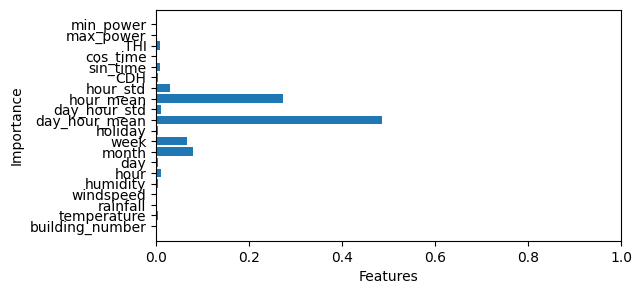

  1%|          | 1/100 [00:03<05:13,  3.16s/it]

SMAPE: 9.240280993209545


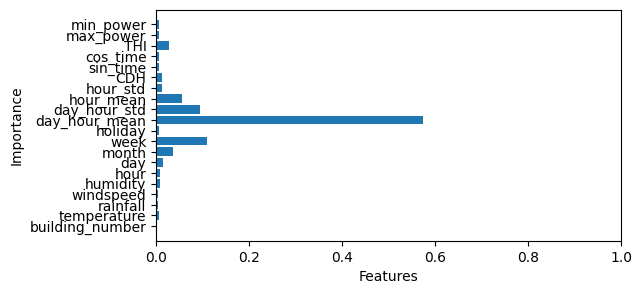

  2%|▏         | 2/100 [00:04<03:46,  2.31s/it]

SMAPE: 18.242662615550095


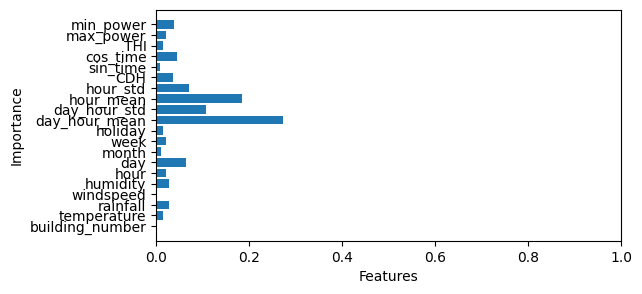

  3%|▎         | 3/100 [00:07<03:45,  2.33s/it]

SMAPE: 7.670146582787472


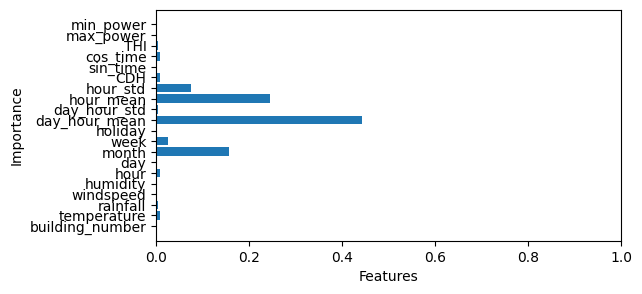

  4%|▍         | 4/100 [00:11<04:54,  3.07s/it]

SMAPE: 8.356728761068064


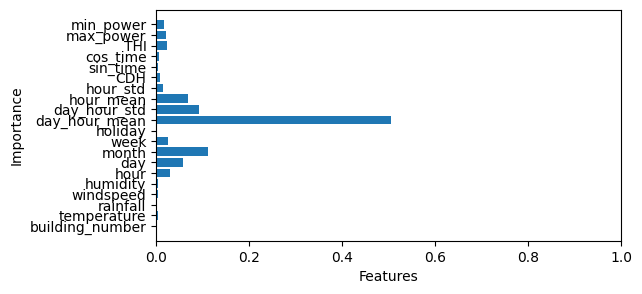

  5%|▌         | 5/100 [00:13<04:10,  2.64s/it]

SMAPE: 5.365727126825137


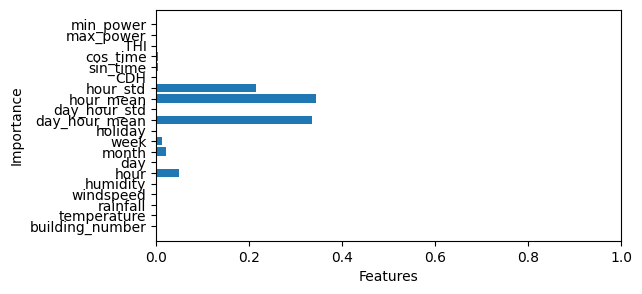

  6%|▌         | 6/100 [00:17<04:49,  3.08s/it]

SMAPE: 8.81227986906209


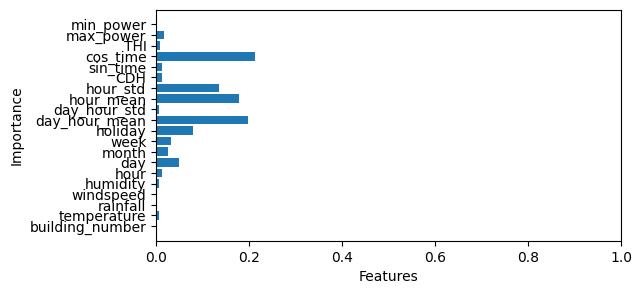

  7%|▋         | 7/100 [00:19<04:19,  2.79s/it]

SMAPE: 5.326796370131407


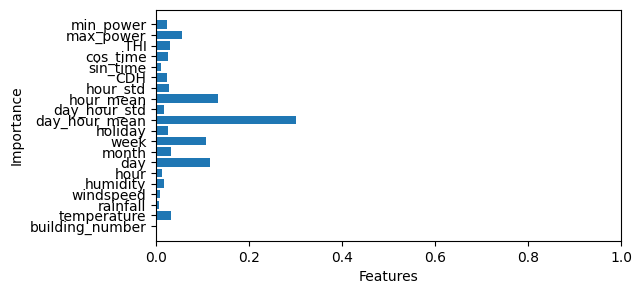

  8%|▊         | 8/100 [00:23<04:51,  3.17s/it]

SMAPE: 2.8361158046712402


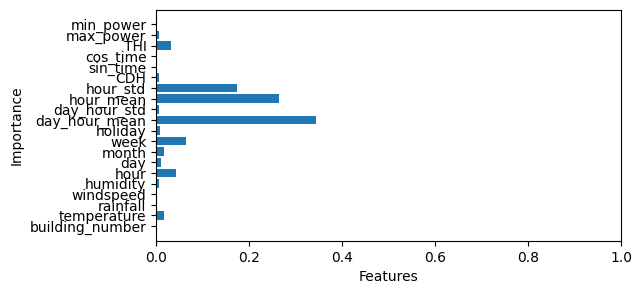

  9%|▉         | 9/100 [00:26<04:47,  3.16s/it]

SMAPE: 10.016264045937753


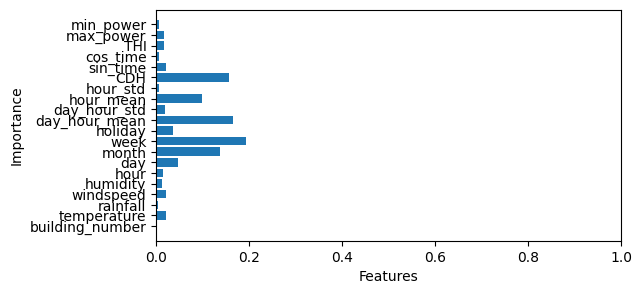

 10%|█         | 10/100 [00:29<04:45,  3.17s/it]

SMAPE: 3.360100486800851


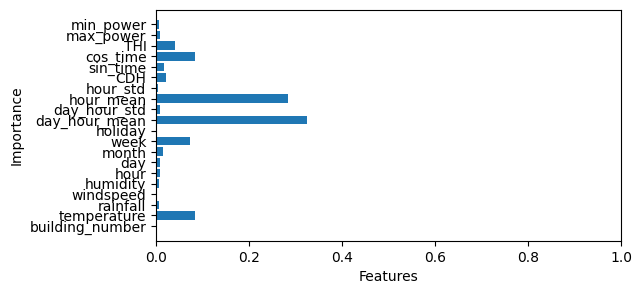

 11%|█         | 11/100 [00:33<04:27,  3.01s/it]


KeyboardInterrupt: 

In [6]:
#smape점수 산출용
preds = np.array([])
smapes = []
missfit_building = []
hyper = pd.read_csv(f'./parameters/hyperparameter_xgb_wsw0808-1540.csv').drop(columns=['Unnamed: 0'])
for i in tqdm(range(100)):
    train_df = pd.read_csv(f'./pretest/train_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pretest_df = pd.read_csv(f'./pretest/pretest_building{i+1}.csv').drop(columns=['Unnamed: 0'])
    pred_df = pd.DataFrame()   # pretest 예측값을 담을 data frame
    
    feature_importances = []
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train_df['power_consumption']
        x_train = train_df.drop(columns=['power_consumption'])
        
        x_pretest = pretest_df.drop(columns=['power_consumption'])
        y_pretest = pretest_df['power_consumption']
        
        xgb = XGBRegressor(seed = seed, tree_method="hist", gpu_id=0,          
                           n_estimators = hyper.iloc[i,6], 
                           eta = hyper.iloc[i, 1],
                           min_child_weight = hyper.iloc[i, 2], max_depth = hyper.iloc[i, 3],
                           colsample_bytree=hyper.iloc[i, 4], subsample=hyper.iloc[i, 5])

        if hyper.iloc[i, 7] != 0:  # 만약 alpha가 0이 아니면 weighted_mse 사용
            xgb.set_params(**{'objective':weighted_mse(hyper.iloc[i,7])})

        xgb.fit(x_train, y_train)
        feature_importances.append(xgb.feature_importances_)
        y_pred = xgb.predict(x_pretest)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
    
    pred = pred_df.mean(axis=1)   # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    pred_np = pred.to_numpy()
    y_pretest_np = y_pretest.to_numpy()
    score = SMAPE(y_pretest_np,pred_np) 
    preds = np.append(preds, pred)
    print("SMAPE:",score)
    average_feature_importances = np.mean(feature_importances, axis=0)
    plt.subplots(figsize=(6, 3))
    plt.barh(x_train.columns, average_feature_importances)
    plt.xlabel('Features')
    plt.xlim(0,1)
    plt.ylabel('Importance')
    plt.show()
    smapes.append(score)
    
    if score > 6:
        missfit_building.append(i)

In [ ]:
print(np.mean(smapes))

6.956177143514923
